In [43]:
%reset -f
import sys
sys.path.insert(0, "..")
from wavhandler import Dataset
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, classification_report, make_scorer, log_loss
from utils_train import *
import deepdish as dd
from configs import DatasetConfiguration
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sb
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed=seed)

splitting = 'custom'
data_setting = 'raw'
model_setting = 'conv1d'

d = Dataset('Wingbeats')
d.read(loadmat=False)

X_train, X_val, X_test, y_train, y_val, y_test, le = mosquito_data_split(splitting=splitting, dataset=d, downsampling=False, return_label_encoder=True)

X_train, X_val, y_train, y_val = X_train[0], X_val[0], y_train[0], y_val[0]
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=seed)
X_val, y_val = shuffle(X_val, y_val, random_state=seed)

get_labelencoder_mapping(le)

## Choosing model (6 classes or 3-merged)

In [43]:
# Merging the mosquito genuses together
y_train = pd.Series(y_train).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
y_val = pd.Series(y_val).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()
y_test = pd.Series(y_test).replace({1:0, 3:2, 5:4}).replace({2:1, 4:2}).tolist()

# Defining model parameters
modelname = f'TL_{splitting}_{data_setting}_{model_setting}_MERGED_weights'
using_conv2d = False
traincf = TrainConfiguration(dataset=d, setting=data_setting, model_name=modelname)
model = ModelConfiguration(model_setting=model_setting, data_setting=data_setting, target_names=traincf.target_names).config

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train_stats = calculate_train_statistics(X_train=X_train, setting=data_setting)

### Model training

In [44]:
h = model.fit_generator(train_generator(X_train, y_train, 
                                    batch_size=traincf.batch_size,
                                    target_names=traincf.target_names,
                                    setting=traincf.setting,
                                    preprocessing_train_stats='',
                                    using_conv2d=using_conv2d),
                    steps_per_epoch = int(math.ceil(float(len(X_train)) / float(traincf.batch_size))),
                    epochs = traincf.epochs,
                    validation_data = valid_generator(X_val, y_val,
                                                        batch_size=traincf.batch_size,
                                                        target_names=traincf.target_names,
                                                        setting=traincf.setting,
                                                        preprocessing_train_stats='',
                                                        using_conv2d=using_conv2d),
                    validation_steps=int(math.ceil(float(len(X_test))/float(traincf.batch_size))),
                    callbacks=traincf.callbacks_list)

Epoch 1/100
5717/5718 [============================>.] - ETA: 0s - loss: 0.2815 - accuracy: 0.8930
Epoch 00001: val_loss improved from inf to 0.94372, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/TL_custom_raw_conv1d_MERGED_weights.h5
5718/5718 [==============================] - 419s 73ms/step - loss: 0.2815 - accuracy: 0.8930 - val_loss: 0.9437 - val_accuracy: 0.7794
Epoch 2/100
5717/5718 [============================>.] - ETA: 0s - loss: 0.1697 - accuracy: 0.9366
Epoch 00002: val_loss improved from 0.94372 to 0.46158, saving model to /home/kalfasyan/projects/wingbeat_frequencies/temp_data/TL_custom_raw_conv1d_MERGED_weights.h5
5718/5718 [==============================] - 417s 73ms/step - loss: 0.1697 - accuracy: 0.9366 - val_loss: 0.4616 - val_accuracy: 0.8726
Epoch 3/100
5717/5718 [============================>.] - ETA: 0s - loss: 0.1419 - accuracy: 0.9474
Epoch 00003: val_loss did not improve from 0.46158
5718/5718 [==============================] - 418s 

In [42]:
# model.load_weights('../temp_data/custom_raw_conv1d_0.h5')

In [45]:
features = model.predict_generator(valid_generator(X_test, y_test, 
                                                  batch_size=traincf.batch_size, 
                                                  setting=traincf.setting, 
                                                  target_names=traincf.target_names,
                                                  preprocessing_train_stats=''),
                                  steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))))

In [46]:
features.shape

(47295, 6)

### Confusion matrix (test set)

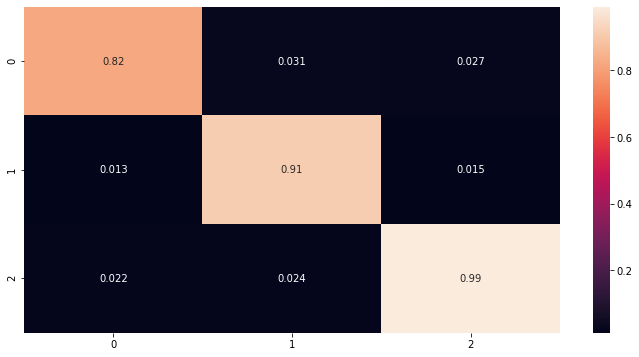

In [54]:
from sklearn.metrics import confusion_matrix
import seaborn as sb
plt.figure(figsize=(12,6))
cm = confusion_matrix(np.argmax(features, axis=1), y_test)
cm = cm.astype(np.float) / cm.astype(np.float).sum(axis=1)
sb.heatmap(cm, annot=True)#, fmt='g')